In [4]:
import pandas as pd

# Read in track metadata with genre labels
# tracks = pd.read_csv('https://github.com/Oysiyl/DataCamp_Solutions_Python/blob/master/Classify%20Song%20Genres%20from%20Audio%20Data/datasets/fma-rock-vs-hiphop.csv')
# tracks = pd.read_csv('Documents/VandyHacks/fma-rock-vs-hiphop.csv')

tracks = pd.read_csv('songDb.tsv', sep = '\t', encoding = "ISO-8859-1")

# Read in track metrics with the features

# echonest_metrics = pd.read_json('Documents/VandyHacks/echonest-metrics.json',precise_float=True)

# Merge the relevant columns of tracks and echonest_metrics
# echo_tracks = echonest_metrics.merge(tracks[['track_id','genre_top']],on='track_id')

# Inspect the resultant dataframe
echo_tracks = tracks
print(tracks.info())
print(tracks.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131580 entries, 0 to 131579
Data columns (total 20 columns):
Name                131578 non-null object
Danceability        131580 non-null float64
Energy              131580 non-null float64
Key                 131580 non-null float64
Loudness            131580 non-null float64
Mode                131580 non-null float64
Speechness          131580 non-null float64
Acousticness        131580 non-null float64
Instrumentalness    131580 non-null float64
Liveness            131580 non-null float64
Valence             131580 non-null float64
Tempo               131580 non-null object
Type                131580 non-null object
ID                  131580 non-null object
Uri                 131580 non-null object
Ref_Track           131580 non-null object
URL_features        131580 non-null object
Duration_ms         131580 non-null float64
time_signature      131580 non-null object
Genre               131554 non-null object
dtypes: float64(11

In [64]:
# Create a correlation matrix
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,Danceability,Energy,Key,Loudness,Mode,Speechness,Acousticness,Instrumentalness,Liveness,Valence,Duration_ms
Danceability,1,0.0835917,0.0279579,0.184349,-0.0585658,0.127518,-0.133843,-0.176297,-0.0966064,0.0729078,-0.0909598
Energy,0.0835917,1,0.0187551,0.752046,-0.0309885,0.110283,-0.697046,-0.152976,0.180375,0.234306,-0.0177309
Key,0.0279579,0.0187551,1,0.0171449,-0.165416,0.0237423,-0.0270715,0.00168188,-0.00345249,-0.0450089,0.0119873
Loudness,0.184349,0.752046,0.0171449,1,-0.0125119,0.043459,-0.601911,-0.371383,0.111435,0.0608335,-0.0964005
Mode,-0.0585658,-0.0309885,-0.165416,-0.0125119,1,-0.0472671,0.0399294,-0.047916,0.00820176,-0.0112964,-0.0452812
Speechness,0.127518,0.110283,0.0237423,0.043459,-0.0472671,1,-0.00662765,-0.115769,0.185848,0.0545706,0.046321
Acousticness,-0.133843,-0.697046,-0.0270715,-0.601911,0.0399294,-0.00662765,1,0.115124,-0.0836535,-0.0238085,-0.0616871
Instrumentalness,-0.176297,-0.152976,0.00168188,-0.371383,-0.047916,-0.115769,0.115124,1,-0.0757605,-0.0455756,0.225799
Liveness,-0.0966064,0.180375,-0.00345249,0.111435,0.00820176,0.185848,-0.0836535,-0.0757605,1,0.0242481,0.0129954
Valence,0.0729078,0.234306,-0.0450089,0.0608335,-0.0112964,0.0545706,-0.0238085,-0.0455756,0.0242481,1,-0.0625084


In [36]:
# Define our features 
features = echo_tracks.drop(['Name', 'Tempo', 'Type', 'ID', 'Uri', 'Ref_Track', 'URL_features', 'Duration_ms','time_signature', 'Genre'], axis=1)

# Define our labels
labels = echo_tracks['Genre']

# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

print(features.info())
# print(labels.shape)

# Scale the features and set the values to a new variable
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131580 entries, 0 to 131579
Data columns (total 10 columns):
Danceability        131580 non-null float64
Energy              131580 non-null float64
Key                 131580 non-null float64
Loudness            131580 non-null float64
Mode                131580 non-null float64
Speechness          131580 non-null float64
Acousticness        131580 non-null float64
Instrumentalness    131580 non-null float64
Liveness            131580 non-null float64
Valence             131580 non-null float64
dtypes: float64(10)
memory usage: 10.0 MB
None


Text(0.5, 0, 'Principal Component #')

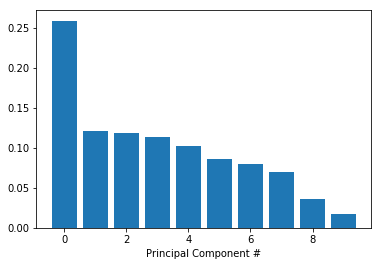

In [18]:
# This is just to make plots appear in the notebook
%matplotlib inline

# Import our plotting module, and PCA class
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

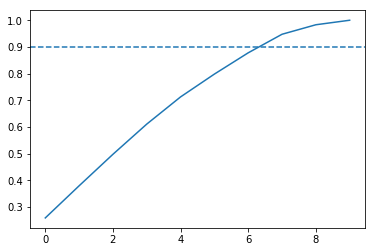

In [19]:
# Import numpy
import numpy as np

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.90.
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.9, linestyle='--')
n_components = 6

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)


In [61]:
# Import train_test_split function and Decision tree classifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, 
                                                                            labels,
                                                                            random_state=10)


train_labels = train_labels.astype(str)
test_labels = test_labels.astype(str)

# Train our decision tree
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)



# # Predict the labels for the test data
pred_labels_tree = tree.predict(test_features)
tree.score(test_features, test_labels)

0.11509347925216598

In [62]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Decision Tree: 
                                  precision    recall  f1-score   support

                    abstractidm       0.02      0.02      0.02        58
                      acappella       0.00      0.00      0.00        33
                   acousticpunk       0.06      0.04      0.04        54
                  africangospel       0.25      0.30      0.28       179
                      afropsych       0.00      0.00      0.00        34
                    alaskaindie       0.02      0.02      0.02       130
                 albanianhiphop       0.24      0.25      0.24       165
                 albertacountry       0.03      0.04      0.03        52
               albuquerqueindie       0.00      0.00      0.00        26
           alternativeamericana       0.47      0.74      0.57       488
                 alternativeemo       0.03      0.07      0.04        43
                 alternativer&b       0.08      0.08      0.08        39
           alternativerootsrock  

In [63]:
# Subset only the hip-hop tracks, and then only the rock tracks
hop_only = echo_tracks[echo_tracks['genre_top']=='Hip-Hop']
rock_only = echo_tracks[echo_tracks['genre_top']=='Rock']
electronic_only = echo_tracks[echo_tracks['genre_top']=='Electronic']
experimental_only = echo_tracks[echo_tracks['genre_top']=='Experimental']
instrumental_only = echo_tracks[echo_tracks['genre_top']=='Instrumental']
folk_only = echo_tracks[echo_tracks['genre_top']=='Folk']
pop_only = echo_tracks[echo_tracks['genre_top']=='Pop']
international_only = echo_tracks[echo_tracks['genre_top']=='International']

# sample the rocks songs to be the same number as there are hip-hop songs
rock_only = rock_only.sample(len(hop_only), random_state=10)
electronic_only = electronic_only.sample(len(hop_only), random_state=10)
experimental_only = experimental_only.sample(len(hop_only), random_state=10)
instrumental_only = instrumental_only.sample(len(hop_only), random_state=10)
folk_only = folk_only.sample(len(hop_only), random_state=10)
pop_only = pop_only.sample(len(hop_only), random_state=10)
international_only = international_only.sample(len(hop_only), random_state=10)

# concatenate the dataframes rock_only and hop_only
rock_hop_bal = pd.concat([rock_only, hop_only, electronic_only, experimental_only, instrumental_only, folk_only, pop_only, international_only])

# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels, random_state=10)

KeyError: 'genre_top'

In [ ]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Compare the models
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

# Set up our K-fold cross-validation
kf = KFold(10, random_state=10)

tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)

# Train our models using KFold cv
tree_score = cross_val_score(tree, pca_projection, labels, cv=kf)
logit_score = cross_val_score(logreg, pca_projection, labels, cv=kf)

# Print the mean of each array of scores
print("Decision Tree:", tree_score, "Logistic Regression:", logit_score)